In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


In [2]:
dataset = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
test = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv')

dataset.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [4]:
object_col = []
bool_col = []
for col in dataset.columns:
    if dataset[col].dtype == 'object':
        object_col.append(col)
    if dataset[col].dtype == 'bool':
        bool_col.append(col)

for i in object_col:
    print(i)

road_type
lighting
weather
time_of_day


In [5]:
for col in object_col: 
    print(f"Column: {col}")
    print(dataset[col].unique())

Column: road_type
['urban' 'rural' 'highway']
Column: lighting
['daylight' 'dim' 'night']
Column: weather
['rainy' 'clear' 'foggy']
Column: time_of_day
['afternoon' 'evening' 'morning']


In [6]:
import category_encoders as ce

enc = ce.TargetEncoder(cols=object_col, smoothing=0.3)
dataset[object_col] = enc.fit_transform(dataset[object_col], dataset["accident_risk"])
test[object_col] = enc.transform(test[object_col])

<Axes: >

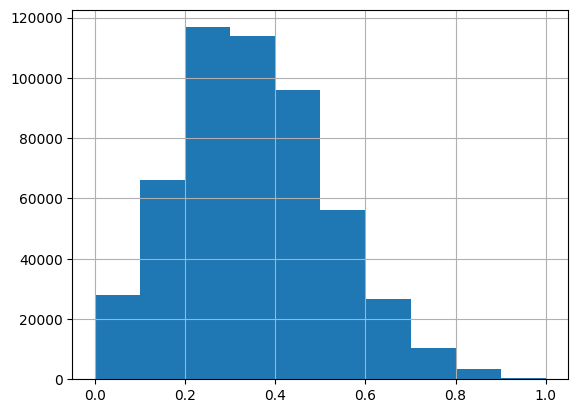

In [7]:
dataset["accident_risk"].hist()

In [8]:
for col in bool_col:
    dataset[col] = dataset[col].astype(int)
    test[col]= test[col].astype(int)

test_ids = test['id']

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  float64
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  float64
 6   weather                 517754 non-null  float64
 7   road_signs_present      517754 non-null  int64  
 8   public_road             517754 non-null  int64  
 9   time_of_day             517754 non-null  float64
 10  holiday                 517754 non-null  int64  
 11  school_season           517754 non-null  int64  
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: float64(6), int64

In [9]:
def new_features(dataset):
    dataset["road_speed_interaction"] = dataset['road_type'] * dataset['speed_limit']
    dataset["curvature_speed"] = dataset['curvature'] * dataset['speed_limit']
    dataset["is_high_risk_road"] = (dataset['num_reported_accidents'] > dataset['num_reported_accidents'].median()).astype(int)
    dataset["complex_road"] = ((dataset['curvature'] > dataset["curvature"].median()) & (dataset['speed_limit'] > dataset['speed_limit'].median())).astype(int)
    dataset["public_with_signs"] = (dataset["public_road"] & dataset["road_signs_present"]).astype(int)
    dataset["holiday_school_overlap"] = (dataset["holiday"] & dataset["school_season"]).astype(int)
    dataset['speed_curvature_ratio'] = dataset['speed_limit'] // (1+dataset['curvature'])
    dataset = dataset.drop(['id'], axis=1)
    return dataset

def add_nonlinear_features(df):
    df = df.copy()
    for c in key_features:
        # квадраты и кубы
        df[f"{c}_sq"] = df[c] ** 2
        df[f"{c}_cube"] = df[c] ** 3
        # sqrt и log (безопасно)
        df[f"{c}_sqrt"] = np.sqrt(np.clip(df[c], 0, None))
        df[f"{c}_log1p"] = np.log1p(np.clip(df[c], 0, None))
        # rank / percentile
        df[f"{c}_rank"] = df[c].rank(method='average') / len(df)
    return df

key_features = ['curvature', 'complex_road', 'curvature_speed', 'weather', 'time_of_day', 'num_reported_accidents']

dataset_new = new_features(dataset)
test = new_features(test)

dataset_new_f = add_nonlinear_features(dataset_new)
test = add_nonlinear_features(test)

In [10]:
from sklearn.model_selection import train_test_split

X = dataset_new_f.drop(['accident_risk'], axis=1)
y = dataset_new_f['accident_risk']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.2)

In [11]:
"""
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def objective_lgb(trial):
    params={
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1),
        "n_estimators": 8000,
        "device_type": "gpu",
        "random_state": 42
    }
    rmse_scores = []
    for train_idx, val_idx in kf.split(X, y):
        model = lgb.LGBMRegressor(
            **params
        )
        model.fit(
            X.iloc[train_idx], y.iloc[train_idx],
            eval_set=[(X.iloc[val_idx], y.iloc[val_idx])],
            eval_metric="rmse",
            callbacks=[lgb.early_stopping(stopping_rounds=200)],
        )
        preds = model.predict(X.iloc[val_idx])
        rmse_scores.append(mean_squared_error(y.iloc[val_idx], preds, squared=False))

    return np.mean(rmse_scores)

study_lgb = optuna.create_study(direction="minimize")
study_lgb.optimize(objective_lgb, n_trials=30)
print("✅ Best LGB params:", study_lgb.best_params)
"""

'\nimport optuna\nfrom sklearn.model_selection import KFold\nfrom sklearn.metrics import mean_squared_error\nimport lightgbm as lgb\nimport numpy as np\n\nkf = KFold(n_splits=5, shuffle=True, random_state=42)\n\ndef objective_lgb(trial):\n    params={\n        \'objective\': \'regression\',\n        \'metric\': \'rmse\',\n        \'num_leaves\': trial.suggest_int(\'num_leaves\', 31, 256),\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.001, 0.05, log=True),\n        \'subsample\': trial.suggest_float(\'subsample\', 0.6, 1),\n        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),\n        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1),\n        "n_estimators": 8000,\n        "device_type": "gpu",\n        "random_state": 42\n    }\n    rmse_scores = []\n    for train_idx, val_idx in kf.split(X, y):\n        model = lgb.LGBMRegressor(\n            **params\n        )\n        model.fit(\n            X.iloc[train_idx], y.iloc[train_idx],

In [12]:
"""
import xgboost as xgb

def objective_xgb(trial):
    params = {
        "objective": "reg:squarederror",
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.05, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "lambda": trial.suggest_float("lambda", 0, 2.0),
        "alpha": trial.suggest_float("alpha", 0, 2.0),
        "n_estimators": 8000,
        "device": "cuda",  
        "random_state": 42
    }
    rmse_scores = []
    for train_idx, val_idx in kf.split(X, y):
        model = xgb.XGBRegressor(
            **params
        )
        model.fit(X.iloc[train_idx], y.iloc[train_idx],
                  eval_set=[(X.iloc[val_idx], y.iloc[val_idx])],
                  early_stopping_rounds=200,
                  verbose=False)
        preds = model.predict(X.iloc[val_idx])
        rmse_scores.append(mean_squared_error(y.iloc[val_idx], preds, squared=False))

    return np.mean(rmse_scores)

study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=30)
print("✅ Best XGB params:", study_xgb.best_params)
"""

'\nimport xgboost as xgb\n\ndef objective_xgb(trial):\n    params = {\n        "objective": "reg:squarederror",\n        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.05, log=True),\n        "max_depth": trial.suggest_int("max_depth", 4, 12),\n        "subsample": trial.suggest_float("subsample", 0.6, 1.0),\n        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),\n        "lambda": trial.suggest_float("lambda", 0, 2.0),\n        "alpha": trial.suggest_float("alpha", 0, 2.0),\n        "n_estimators": 8000,\n        "device": "cuda",  \n        "random_state": 42\n    }\n    rmse_scores = []\n    for train_idx, val_idx in kf.split(X, y):\n        model = xgb.XGBRegressor(\n            **params\n        )\n        model.fit(X.iloc[train_idx], y.iloc[train_idx],\n                  eval_set=[(X.iloc[val_idx], y.iloc[val_idx])],\n                  early_stopping_rounds=200,\n                  verbose=False)\n        preds = model.predict(X.iloc[val_idx

In [13]:
"""
from catboost import CatBoostRegressor

def objective_cat(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.05, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "bootstrap_type": "Bernoulli", 
        "iterations": 8000,
        "task_type": "GPU",
        "random_seed": 42,
        "loss_function": "RMSE",
        "verbose": False
    }
    rmse_scores = []
    for train_idx, val_idx in kf.split(X, y):
        model = xgb.XGBRegressor(
            **params
        )
        model.fit(X.iloc[train_idx], y.iloc[train_idx],
                  eval_set=[(X.iloc[val_idx], y.iloc[val_idx])],
                  early_stopping_rounds=200,
                  verbose=False)
        preds = model.predict(X.iloc[val_idx])
        rmse_scores.append(mean_squared_error(y.iloc[val_idx], preds, squared=False))

    return np.mean(rmse_scores)

study_cat = optuna.create_study(direction="minimize")
study_cat.optimize(objective_cat, n_trials=30)
print("✅ Best Cat params:", study_cat.best_params)
"""

'\nfrom catboost import CatBoostRegressor\n\ndef objective_cat(trial):\n    params = {\n        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.05, log=True),\n        "depth": trial.suggest_int("depth", 4, 10),\n        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),\n        "subsample": trial.suggest_float("subsample", 0.6, 1.0),\n        "bootstrap_type": "Bernoulli", \n        "iterations": 8000,\n        "task_type": "GPU",\n        "random_seed": 42,\n        "loss_function": "RMSE",\n        "verbose": False\n    }\n    rmse_scores = []\n    for train_idx, val_idx in kf.split(X, y):\n        model = xgb.XGBRegressor(\n            **params\n        )\n        model.fit(X.iloc[train_idx], y.iloc[train_idx],\n                  eval_set=[(X.iloc[val_idx], y.iloc[val_idx])],\n                  early_stopping_rounds=200,\n                  verbose=False)\n        preds = model.predict(X.iloc[val_idx])\n        rmse_scores.append(mean_squared_error(y.iloc[val_

In [14]:
"""
import json

# Сохраняем лучшие параметры в JSON
with open("best_params_lgb.json", "w") as f:
    json.dump(study_lgb.best_params, f, indent=4)

with open("best_params_xgb.json", "w") as f:
    json.dump(study_xgb.best_params, f, indent=4)

with open("best_params_cat.json", "w") as f:
    json.dump(study_cat.best_params, f, indent=4)
"""

'\nimport json\n\n# Сохраняем лучшие параметры в JSON\nwith open("best_params_lgb.json", "w") as f:\n    json.dump(study_lgb.best_params, f, indent=4)\n\nwith open("best_params_xgb.json", "w") as f:\n    json.dump(study_xgb.best_params, f, indent=4)\n\nwith open("best_params_cat.json", "w") as f:\n    json.dump(study_cat.best_params, f, indent=4)\n'

In [15]:
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "lgb": lgb.LGBMRegressor(
         objective='regression',
         learning_rate= 0.0032244179983577357,
         num_leaves=227,
         n_estimators=8000,
         subsample=0.7863943434859237,
         colsample_bytree=0.6957862516136889,
         reg_alpha= 0.1,
         reg_lambda=0.31826064654131414,
         random_state=42,
         device='gpu',
         metric='rmse'
    ),
    "xgb":xgb.XGBRegressor(
         n_estimators=8000,
         learning_rate=0.0016903895754495771,
         max_depth=9,
         subsample=0.8091759938762744,
         colsample_bytree=0.6277855134149923,
         reg_alpha=0.9748855006408157,
         reg_lambda=0.2029674804310182,
         objective="reg:squarederror",
         tree_method="hist",
         device='cuda', 
         random_state=42,
         verbose=False
    ),
    "cat":CatBoostRegressor(
        learning_rate=0.0497748782098144,
        depth=10,
        iterations=8000,
        random_seed=42,
        task_type='GPU', 
        subsample=0.7586510969885926,
        l2_leaf_reg=4.328460970987645,
        loss_function='RMSE',
        bootstrap_type='Bernoulli',
        verbose=False
    )
    
}

oof_preds = {name: np.zeros(len(X)) for name in models}
test_preds = {name: np.zeros(len(test)) for name in models}

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\n===== FOLD {fold+1} =====")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    for name, model in models.items():
        print(f"model train: {name}")
        if name == "lgb":
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric='rmse',
                callbacks=[
                    lgb.early_stopping(stopping_rounds=300, verbose=False),
                    lgb.log_evaluation(period=200)
                ],
            )
            oof_preds[name][val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
            test_preds[name] += model.predict(test, num_iteration=model.best_iteration_) / kf.n_splits

        elif name == "xgb":
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric='rmse',
                early_stopping_rounds=300,
            )
            oof_preds[name][val_idx] = model.predict(X_val, iteration_range=(0, model.best_iteration))
            test_preds[name] += model.predict(test, iteration_range=(0, model.best_iteration)) / kf.n_splits

        elif name == "cat":
            model.fit(
                X_train, y_train,
                eval_set=(X_val, y_val),
                early_stopping_rounds=300
            )
            oof_preds[name][val_idx] = model.predict(X_val) 
            test_preds[name] += model.predict(test) / kf.n_splits
            


===== FOLD 1 =====
model train: lgb
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2506
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 49
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 40 dense feature groups (15.80 MB) transferred to GPU in 0.016368 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.352605
[200]	valid_0's rmse: 0.104648
[400]	valid_0's rmse: 0.0752328
[600]	valid_0's rmse: 0.063123
[800]	valid_0's rmse: 0.0586827
[1000]	valid_0's rmse: 0.057111
[1200]	valid_0's rmse: 0.0565408
[1400]	valid_0's rmse: 0.0563306
[1600]	valid_0's rmse: 0.0562491
[1800]	valid_0's rmse: 0.0562154
[2000]	valid_0's rmse: 0.0562011
[2200]	valid_0's rmse: 0.0561958
[2400]	valid_0's rmse: 0.056195
[2600]	valid_0's rmse: 0.0561963
model train: xgb


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [08:34:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:0.16593
[1]	validation_0-rmse:0.16568
[2]	validation_0-rmse:0.16543
[3]	validation_0-rmse:0.16519
[4]	validation_0-rmse:0.16501
[5]	validation_0-rmse:0.16483
[6]	validation_0-rmse:0.16459
[7]	validation_0-rmse:0.16435
[8]	validation_0-rmse:0.16417
[9]	validation_0-rmse:0.16393
[10]	validation_0-rmse:0.16368
[11]	validation_0-rmse:0.16345
[12]	validation_0-rmse:0.16321
[13]	validation_0-rmse:0.16296
[14]	validation_0-rmse:0.16272
[15]	validation_0-rmse:0.16248
[16]	validation_0-rmse:0.16224
[17]	validation_0-rmse:0.16200
[18]	validation_0-rmse:0.16177
[19]	validation_0-rmse:0.16153
[20]	validation_0-rmse:0.16136
[21]	validation_0-rmse:0.16112
[22]	validation_0-rmse:0.16088
[23]	validation_0-rmse:0.16071
[24]	validation_0-rmse:0.16048
[25]	validation_0-rmse:0.16024
[26]	validation_0-rmse:0.16007
[27]	validation_0-rmse:0.15984
[28]	validation_0-rmse:0.15967
[29]	validation_0-rmse:0.15943
[30]	validation_0-rmse:0.15920
[31]	validation_0-rmse:0.15896
[32]	validation_0-

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [08:35:50] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


model train: cat

===== FOLD 2 =====
model train: lgb
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2506
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 49
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 40 dense feature groups (15.80 MB) transferred to GPU in 0.016577 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.352104
[200]	valid_0's rmse: 0.104767
[400]	valid_0's rmse: 0.0752162
[600]	valid_0's rmse: 0.063028
[800]	valid_0's rmse: 0.0585648
[1000]	valid_0's rmse: 0.0569809
[1200]	valid_0's rmse: 0.0564108
[1400]	valid_0's rmse: 0.0562044
[1600]	valid_0's rmse: 0.0561246
[1800]	valid_0's rmse: 0.0560907
[2000]	valid_0's rmse: 0.0560772
[2200]	valid_0's rmse: 0.0560749
[2400]	valid_0's rmse:

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [08:39:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-rmse:0.16487
[7]	validation_0-rmse:0.16463
[8]	validation_0-rmse:0.16445
[9]	validation_0-rmse:0.16421
[10]	validation_0-rmse:0.16396
[11]	validation_0-rmse:0.16372
[12]	validation_0-rmse:0.16348
[13]	validation_0-rmse:0.16324
[14]	validation_0-rmse:0.16300
[15]	validation_0-rmse:0.16276
[16]	validation_0-rmse:0.16252
[17]	validation_0-rmse:0.16228
[18]	validation_0-rmse:0.16204
[19]	validation_0-rmse:0.16180
[20]	validation_0-rmse:0.16163
[21]	validation_0-rmse:0.16139
[22]	validation_0-rmse:0.16116
[23]	validation_0-rmse:0.16099
[24]	validation_0-rmse:0.16075
[25]	validation_0-rmse:0.16051
[26]	validation_0-rmse:0.16034
[27]	validation_0-rmse:0.16011
[28]	validation_0-rmse:0.15994
[29]	validation_0-rmse:0.15970
[30]	validation_0-rmse:0.15947
[31]	validation_0-rmse:0.15923
[32]	validation_0-rmse:0.15900
[33]	validation_0-rmse:0.15883
[34]	validation_0-rmse:0.15860
[35]	validation_0-rmse:0.15843
[36]	validation_0-rmse:0.15820
[37]	validation_0-rmse:0.15803
[38]	validat

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [08:44:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-rmse:0.16530
[7]	validation_0-rmse:0.16505
[8]	validation_0-rmse:0.16488
[9]	validation_0-rmse:0.16463
[10]	validation_0-rmse:0.16439
[11]	validation_0-rmse:0.16415
[12]	validation_0-rmse:0.16391
[13]	validation_0-rmse:0.16366
[14]	validation_0-rmse:0.16342
[15]	validation_0-rmse:0.16318
[16]	validation_0-rmse:0.16294
[17]	validation_0-rmse:0.16269
[18]	validation_0-rmse:0.16246
[19]	validation_0-rmse:0.16222
[20]	validation_0-rmse:0.16205
[21]	validation_0-rmse:0.16181
[22]	validation_0-rmse:0.16157
[23]	validation_0-rmse:0.16140
[24]	validation_0-rmse:0.16116
[25]	validation_0-rmse:0.16092
[26]	validation_0-rmse:0.16075
[27]	validation_0-rmse:0.16052
[28]	validation_0-rmse:0.16035
[29]	validation_0-rmse:0.16011
[30]	validation_0-rmse:0.15987
[31]	validation_0-rmse:0.15964
[32]	validation_0-rmse:0.15940
[33]	validation_0-rmse:0.15923
[34]	validation_0-rmse:0.15900
[35]	validation_0-rmse:0.15883
[36]	validation_0-rmse:0.15860
[37]	validation_0-rmse:0.15843
[38]	validat

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [08:49:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-rmse:0.16442
[7]	validation_0-rmse:0.16418
[8]	validation_0-rmse:0.16400
[9]	validation_0-rmse:0.16376
[10]	validation_0-rmse:0.16352
[11]	validation_0-rmse:0.16328
[12]	validation_0-rmse:0.16304
[13]	validation_0-rmse:0.16280
[14]	validation_0-rmse:0.16256
[15]	validation_0-rmse:0.16231
[16]	validation_0-rmse:0.16207
[17]	validation_0-rmse:0.16183
[18]	validation_0-rmse:0.16160
[19]	validation_0-rmse:0.16136
[20]	validation_0-rmse:0.16119
[21]	validation_0-rmse:0.16095
[22]	validation_0-rmse:0.16072
[23]	validation_0-rmse:0.16055
[24]	validation_0-rmse:0.16031
[25]	validation_0-rmse:0.16007
[26]	validation_0-rmse:0.15990
[27]	validation_0-rmse:0.15967
[28]	validation_0-rmse:0.15950
[29]	validation_0-rmse:0.15926
[30]	validation_0-rmse:0.15903
[31]	validation_0-rmse:0.15879
[32]	validation_0-rmse:0.15856
[33]	validation_0-rmse:0.15839
[34]	validation_0-rmse:0.15816
[35]	validation_0-rmse:0.15799
[36]	validation_0-rmse:0.15776
[37]	validation_0-rmse:0.15759
[38]	validat

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [08:55:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-rmse:0.16521
[6]	validation_0-rmse:0.16497
[7]	validation_0-rmse:0.16472
[8]	validation_0-rmse:0.16454
[9]	validation_0-rmse:0.16430
[10]	validation_0-rmse:0.16406
[11]	validation_0-rmse:0.16382
[12]	validation_0-rmse:0.16358
[13]	validation_0-rmse:0.16333
[14]	validation_0-rmse:0.16309
[15]	validation_0-rmse:0.16285
[16]	validation_0-rmse:0.16261
[17]	validation_0-rmse:0.16237
[18]	validation_0-rmse:0.16213
[19]	validation_0-rmse:0.16189
[20]	validation_0-rmse:0.16172
[21]	validation_0-rmse:0.16148
[22]	validation_0-rmse:0.16125
[23]	validation_0-rmse:0.16108
[24]	validation_0-rmse:0.16084
[25]	validation_0-rmse:0.16060
[26]	validation_0-rmse:0.16043
[27]	validation_0-rmse:0.16019
[28]	validation_0-rmse:0.16002
[29]	validation_0-rmse:0.15979
[30]	validation_0-rmse:0.15955
[31]	validation_0-rmse:0.15932
[32]	validation_0-rmse:0.15908
[33]	validation_0-rmse:0.15892
[34]	validation_0-rmse:0.15868
[35]	validation_0-rmse:0.15852
[36]	validation_0-rmse:0.15828
[37]	validati

In [16]:
"""
y_segment = (y_train > 0.5).astype(int)
#Классификатор сегментов
clf = lgb.LGBMClassifier(
    objective = 'binary',
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
clf.fit(X_train, y_segment, 
        eval_set=[(X_test, (y_test > 0.5).astype(int))],
        eval_metric=['auc'],
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
       )

model_all = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.005,
    num_leaves=128,
    n_estimators=8000,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.3,
    random_state=42
)
model_all.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=300)]
)
#Регрессоры для сегментов

X_train_0, X_val_0, y_train_0, y_val_0 = train_test_split(
    X_train[y_train <= 0.5],
    y_train[y_train <= 0.5],
    test_size=0.2,
    random_state=42
)

model_0 = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.01,
    num_leaves=128,
    n_estimators=5000,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.3,
    random_state=42
)
model_0.fit(
    X_train_0, y_train_0,
    eval_set=[(X_val_0, y_val_0)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(
    X_train[y_train > 0.5],
    y_train[y_train > 0.5],
    test_size=0.2,
    random_state=42
)

model_1 = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.01,
    num_leaves=128,
    n_estimators=5000,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.3,
    random_state=42
)
model_1.fit(
    X_train_1, y_train_1,
    eval_set=[(X_val_1, y_val_1)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)
"""

"\ny_segment = (y_train > 0.5).astype(int)\n#Классификатор сегментов\nclf = lgb.LGBMClassifier(\n    objective = 'binary',\n    learning_rate=0.05,\n    num_leaves=31,\n    n_estimators=1000,\n    subsample=0.8,\n    colsample_bytree=0.8,\n    random_state=42\n)\nclf.fit(X_train, y_segment, \n        eval_set=[(X_test, (y_test > 0.5).astype(int))],\n        eval_metric=['auc'],\n        callbacks=[lgb.early_stopping(stopping_rounds=50)]\n       )\n\nmodel_all = lgb.LGBMRegressor(\n    objective='regression',\n    learning_rate=0.005,\n    num_leaves=128,\n    n_estimators=8000,\n    subsample=0.8,\n    colsample_bytree=0.8,\n    reg_alpha=0.1,\n    reg_lambda=0.3,\n    random_state=42\n)\nmodel_all.fit(\n    X_train, y_train,\n    eval_set=[(X_test, y_test)],\n    eval_metric='rmse',\n    callbacks=[lgb.early_stopping(stopping_rounds=300)]\n)\n#Регрессоры для сегментов\n\nX_train_0, X_val_0, y_train_0, y_val_0 = train_test_split(\n    X_train[y_train <= 0.5],\n    y_train[y_train <= 0.

In [17]:
"""
# Предсказания сегмента
seg_prob = clf.predict_proba(test)[:,1]

# Предсказания регрессоров
y_pred_0 = model_0.predict(test)
y_pred_1 = model_1.predict(test)

# Мягкое объединение
y_pred = (1 - seg_prob) * y_pred_0 + seg_prob * y_pred_1

# Ограничение диапазона 0-1
y_pred = np.clip(y_pred, 0, 1)

y_pred = model_all.predict(test)
"""

'\n# Предсказания сегмента\nseg_prob = clf.predict_proba(test)[:,1]\n\n# Предсказания регрессоров\ny_pred_0 = model_0.predict(test)\ny_pred_1 = model_1.predict(test)\n\n# Мягкое объединение\ny_pred = (1 - seg_prob) * y_pred_0 + seg_prob * y_pred_1\n\n# Ограничение диапазона 0-1\ny_pred = np.clip(y_pred, 0, 1)\n\ny_pred = model_all.predict(test)\n'

In [18]:
X_meta = np.vstack([oof_preds[m] for m in models]).T
X_test_meta = np.vstack([test_preds[m] for m in models]).T

meta_model = Ridge(alpha=1.0)
meta_model.fit(X_meta, y)

final_test_pred = meta_model.predict(X_test_meta)

In [19]:
submission = pd.DataFrame({
    'id': test_ids,   # или любая колонка с идентификатором
    'accident_risk': final_test_pred
})
submission.to_csv('submission.csv', index=False)

<Axes: >

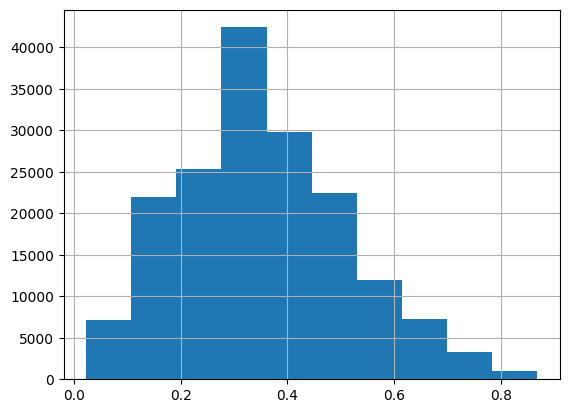

In [20]:
submission['accident_risk'].hist()